# Strain mapping with all calibrations
___

## 2C: Calibration - Pixel calibration

Measure the pixel size on the detector after elliptical distortion correction, using the known calibration sample spacings.
___

- Inputs:
  - Bragg vector map, corrected, for the calibration sample
- Outputs:
  - Q pixel size

### Import packages, load data

In [1]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Ellipse
from time import time
from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import curve_fit

# i/o
from py4DSTEM.file.datastructure import DiffractionSlice, RealSlice
from py4DSTEM.file.io import FileBrowser, read, append

# Diffraction shift correction
from py4DSTEM.process.utils import get_CoM
from py4DSTEM.process.calibration import get_diffraction_shifts, find_outlier_shifts, shift_braggpeaks
from py4DSTEM.process.fit import fit_2D
from py4DSTEM.process.braggdiskdetection import get_bragg_vector_map

# Elliptical distortion correction
from py4DSTEM.process.utils import radial_integral, get_maxima_1D
from py4DSTEM.process.calibration import measure_elliptical_distortion, correct_elliptical_distortion

In [6]:
# Examine contents of processing_sampledata.h5

fp_processing = "/media/AuxDriveB/Data/20190904_StrainMappingExample_with_Calibrations/LFP100_P1/processing_sampledata.h5"
browser = py4DSTEM.file.io.FileBrowser(fp_processing)
browser.show_dataobjects()

 Index                  Name                        Type        
   0    braggvectormap_calibrationdata_shiftcorrectedDiffractionSlice    
   1    braggvectormap_corrected_calibrationdataDiffractionSlice    
   2    braggvectormap_uncorrected_calibrationdataDiffractionSlice    
   3    probe                               DiffractionSlice    
   4    diffractionshifts_calibrationdata   RealSlice           
   5    virtual_image                       RealSlice           
   6    elliptical_distortion               PointList           
   7    braggpeaks_corrected_calibrationdataPointListArray      
   8    braggpeaks_uncorrected_calibrationdataPointListArray      


In [7]:
# Load data

braggvectormap = browser.get_dataobject('braggvectormap_corrected_calibrationdata').data
browser.close()

Q_Nx,Q_Ny = braggvectormap.shape

### Measure Q pixel size

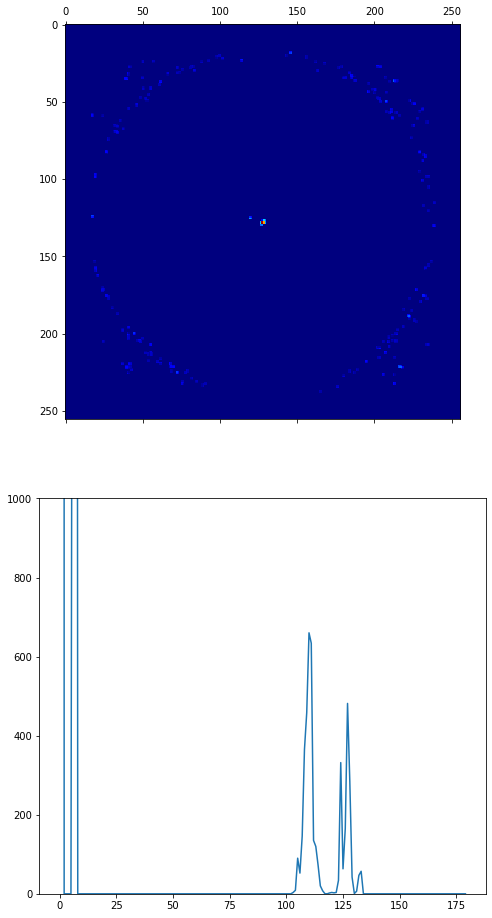

In [8]:
# Show Bragg vector map, calculate radial integral

ymax=1000
power=0.25

x0,y0 = np.unravel_index(np.argmax(gaussian_filter(braggvectormap,2)),(Q_Nx,Q_Ny))
radial_profile = radial_integral(braggvectormap,x0,y0)[0]

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(8,16))
ax1.matshow(braggvectormap**power,cmap='jet')
ax2.plot(np.arange(len(radial_profile)),radial_profile)
ax2.set_ylim(0,ymax)
plt.show()

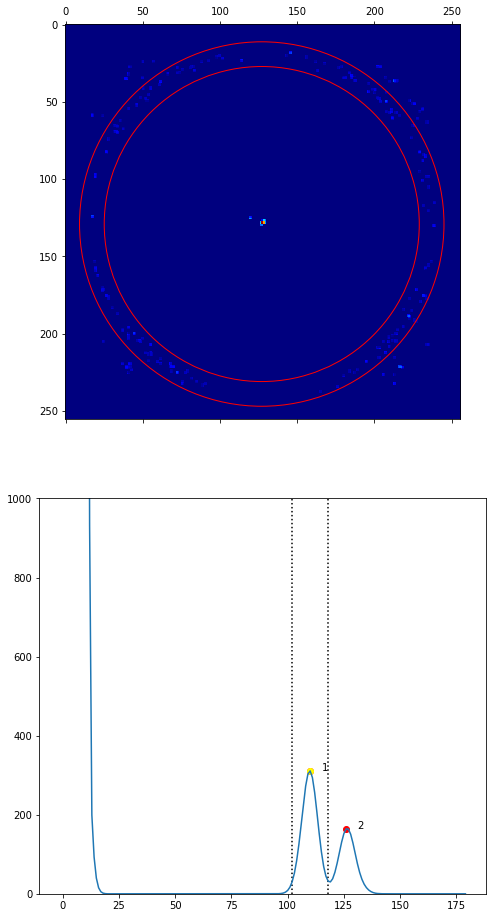

In [9]:
# Get radial profile maxima, and select one

##### Parameters #####
# Find maxima
sigma = 3
minSpacing = 10
minRelativeIntensity = 0.01
relativeToPeak = 1

# Select a maximum
selected_index = 1
annulus_width = 16

# Display params
text_offset = 5
power = 0.25
#######################

maxima = get_maxima_1D(radial_profile, sigma=sigma, minSpacing=minSpacing,
                       minRelativeIntensity=minRelativeIntensity,
                       relativeToPeak=relativeToPeak)

r_peak = maxima[selected_index]
r_inner = r_peak - annulus_width/2.
r_outer = r_peak + annulus_width/2.

# Show
profile_smoothed = gaussian_filter(radial_profile,sigma)
fig,(ax2,ax1) = plt.subplots(2,1,figsize=(8,16))
ax1.plot(np.arange(len(profile_smoothed)),profile_smoothed)
ax1.scatter(maxima,profile_smoothed[maxima],color='r')
for i in range(len(maxima)):
    if profile_smoothed[maxima[i]] < ymax:
        ax1.text(maxima[i]+text_offset,profile_smoothed[maxima[i]],'{}'.format(i))
ax1.scatter(r_peak,profile_smoothed[r_peak],color='yellow')
ax1.vlines((r_inner,r_outer),0,ax1.get_ylim()[1],linestyle=":")
ax1.set_ylim(0,ymax)

ax2.matshow(braggvectormap**power,cmap='jet')
circle_inner = Circle((y0,x0),radius=r_inner, fill=False, edgecolor='r', linestyle="-")
circle_outer = Circle((y0,x0),radius=r_outer, fill=False, edgecolor='r', linestyle="-")
ax2.add_patch(circle_inner)
ax2.add_patch(circle_outer)

plt.show()

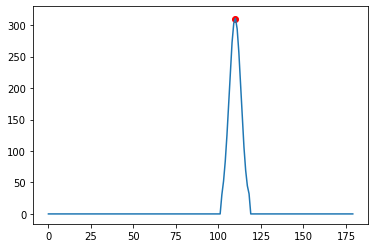

In [10]:
# Fit a gaussian to find peak spacing

mask = (r_inner<=np.arange(len(profile_smoothed))) * (r_outer>=np.arange(len(profile_smoothed)))
data = profile_smoothed * mask

gaussian = lambda x, A, mu,sigma: A*np.exp(-0.5*((x-mu)/sigma)**2)
xmin = np.min(np.nonzero(mask)[0])
xwidth = sum(mask)
data_xvals = np.arange(xwidth)
data_yvals = profile_smoothed[xmin:xmin+xwidth]
popt_guess = [np.max(data_yvals),np.argmax(data_yvals),(r_outer-r_inner)/4.]
popt,_ = curve_fit(gaussian,data_xvals,data_yvals,popt_guess)
mu = xmin+popt[1]

fig,ax = plt.subplots()
ax.plot(np.arange(len(data)),data)
ax.scatter(mu,popt[0],color='r')
plt.show()

In [11]:
# Get pixel calibration

d_spacing_A = 2.338                            # in Angstroms, from TedPella product description - Diffraction Standard Evaporated Aluminum, prod. no. 619
inv_A_per_pixel = 1./(d_spacing_A * (mu+0.5))  # The extra factor of 0.5 accounts for the binning of the radial profiles
                                               # In the radial profile outputs, the n'th entry corresponds to a bin 
                                               # from n to n+1, so the +0.5 gives the bin center.

### Save

In [12]:
# Store relevant data in  DataObjects

# Pixel size is saved as a PointList for now.  TODO: save instead in metadata
coords = [('inv_A_per_pixel',float)]
Qpix_calibration = py4DSTEM.file.datastructure.PointList(coordinates=coords)
Qpix_calibration.add_point((inv_A_per_pixel,))
Qpix_calibration.name = "Qpixel_calibration"

In [13]:
# Append to processing file

dataobjects = [Qpix_calibration]

append(dataobjects, fp_processing)

Opening file /media/AuxDriveB/Data/20190904_StrainMappingExample_with_Calibrations/LFP100_P1/processing_sampledata.h5...
Done.
